Loss after iteration 0: 30.915926
iteration: 0
Loss after iteration 1000: 0.032903
Loss after iteration 2000: 0.025314
Loss after iteration 3000: 0.021082
Loss after iteration 4000: 0.018169
Loss after iteration 5000: 0.016314
Loss after iteration 6000: 0.015110
Loss after iteration 7000: 0.014301
Loss after iteration 8000: 0.013716
Loss after iteration 9000: 0.013282
Loss after iteration 10000: 0.012941
iteration: 10000
Loss after iteration 11000: 0.012665
Loss after iteration 12000: 0.012444
Loss after iteration 13000: 0.012243
Loss after iteration 14000: 0.012072
Loss after iteration 15000: 0.011917
Loss after iteration 16000: 0.011775
Loss after iteration 17000: 0.011641
Loss after iteration 18000: 0.011515
Loss after iteration 19000: 0.011391
Loss after iteration 20000: 0.011281
iteration: 20000
Loss after iteration 21000: 0.011156
Loss after iteration 22000: 0.011031
Loss after iteration 23000: 0.010901
Loss after iteration 24000: 0.010777
Loss after iteration 25000: 0.010639
Los

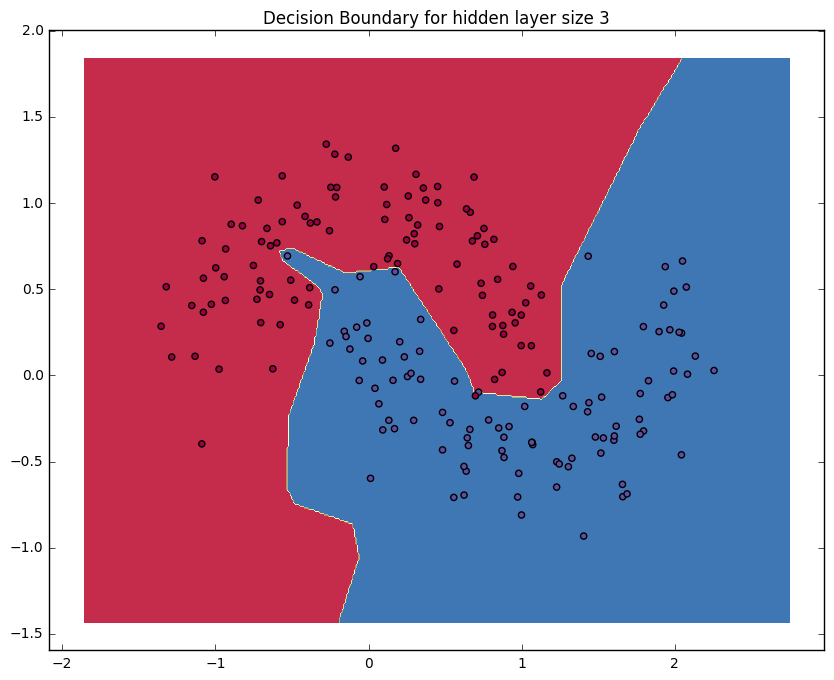

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

"""
1、改成3层网络（2 hidden layers）
2、改成使用relu作为激活函数
"""


# 绘图
def plot_decision_boundary(X, y, pred_func):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

# 准备数据
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
# X的一个item是一个二维向量或者二维坐标(x1,x2), y的一个item是标量0或者1
relu_value = 0.001

def relu(x):
    res = np.copy(x)
    res[x <= 0] *= relu_value
    return res

def dfn_relu(x):
    res = np.ones(x.shape)
    res[x < 0] = relu_value
    return res

num_examples = len(X) # 训练集数据条数
nn_input_dim = 2 # 输入维数
nn_output_dim = 2 # 输出维数
epsilon = 0.001 # 梯度下降学习率
reg_lambda = 0.01 # 标准化强度。就是把参数拉着不让它更新. 可以有效降低训练速度。
dfn = dfn_relu
activation_fn = relu

def do_work(x, model, target=None, only_predict=False):
    a0 = x

    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    # 计算神经网络的输出
    z1 = a0.dot(W1) + b1
    a1 = activation_fn(z1)
    z2 = a1.dot(W2) + b2
    a2 = activation_fn(z2)
    z3 = a2.dot(W3) + b3

    # 根据softmax的公式，将数据映射到(0,1)
    exp_scores = np.exp(z3) # 将数值映射为正数，就可以不考虑负数的情况
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # 计算每个输出占据总输出的比例，作为选择该分类的概率
        # 不需要每个分类的概率时，也可以直接返回 np.argmax(exp_scores, axis=1)

    if not only_predict:
        # BP反向传播计算delta
        delta4 = probs

        delta4[range(num_examples), target] -= 1        
        dW3 = (a2.T).dot(delta4)  # (200x10).T * (200x2)  # a1.T * a2 = (a2.T * a1).T
        db3 = np.sum(delta4, axis=0, keepdims=True)
        
        delta3 = delta4.dot(W3.T) * dfn(a2)
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)

        delta2 = delta3.dot(W2.T) * dfn(a1)
        dW1 = (a0.T).dot(delta2)
        db1 = np.sum(delta2, axis=0, keepdims=True)

        # 用目前的值做校正
        dW3 += reg_lambda * W3
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        # 用delta更新参数
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        W3 += -epsilon * dW3
        b3 += -epsilon * db3
        
        model.update({ 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3})
    return probs

def calculate_loss(X, y, model):
    # 计算神经网络输出
    probs = do_work(X, model, only_predict=True)
    # 计算与标签值的误差
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    corect_logprobs = -np.log(probs[range(num_examples), y]) # 把标签值对应的预测概率选出来。这些值在 (0,1) 之间。
        # 计算 -log 值，将 (0,1) 映射到 (INF,0)。如果误差小，则选出来的值应该接近 1，-log 之后应该接近 0
    data_loss = np.sum(corect_logprobs) # 所以算出来的 sum 也应该接近 0
    # data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./ num_examples * data_loss # 每条训练数据的平均误差

# Helper function to predict an output (0 or 1)
def predict(model, x):
    # 计算每个分类的概率
    probs = do_work(x, model, only_predict=True)
    # 返回概率最大的那个分类
    return np.argmax(probs, axis=1) # np里面的操作默认是按列进行（axis=0），axis=1表示按行进行

def build_model(X, y, nn_hdim):
    # 使用随机值来创建初始神经网络
    import time
    np.random.seed(19930928)
    init_x = -3
    init_y = 3
    W1 = np.random.uniform(init_x, init_y, (nn_input_dim,nn_hdim))
    b1 = np.random.uniform(init_x, init_y, (1,nn_hdim))
    W2 = np.random.uniform(init_x, init_y, (nn_hdim, nn_hdim))
    b2 = np.random.uniform(init_x, init_y, (1, nn_hdim))
    W3 = np.random.uniform(init_x, init_y, (nn_hdim,nn_output_dim))
    b3 = np.random.uniform(init_x, init_y, (1,nn_output_dim))
    
    # 保存神经网络的最终结果
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # BP方式来更新神经网络
    last_loss = 1
    for i in range(300000):
        # 更新模型
        do_work(X, model, target=y, only_predict=False)
        # 误差已经足够小了就退出
        if i % 1000 == 0:
            loss = calculate_loss(X, y, model)
            print "Loss after iteration %i: %f" %(i, loss)
            if loss < 0.02:  # loss足够小的时候降低一点学习率，更精细地训练
                epsilon = 0.008
            if loss < 0.01: # 目标loss是0.01时，基本上二分之后就是100%准确地过拟合了
                break
        if i % 10000 == 0:
            print 'iteration: %s' % i
    return model

# 使用三个神经元的隐含层
model = build_model(X, y, 10)  # 很NB啊，10x10两层就轻松达到了单层250神经元的效果

# 绘图
def pred(x):
    print x
    return predict(model, x)
plot_decision_boundary(X, y, pred)
plt.title("Decision Boundary for hidden layer size 3")